In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentimentanalysistest/sentimentanalysistest.csv


In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/sentimentanalysistest/sentimentanalysistest.csv", encoding="ISO-8859-1")




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re



In [4]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, Dense, Dropout,Input
from tensorflow.keras.models import Model

In [6]:
df=df[["text", "sentiment"]]
print(df.head())

                                                text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  positive
2  Recession hit Veronique Branquinho, she has to...  negative
3                                        happy bday!  positive
4             http://twitpic.com/4w75p - I like it!!  positive


In [7]:
def clean_text(text):
  text=str(text).lower()
  text=re.sub(r"https\S+", "", text)
  text=re.sub(r"@\w+", "", text)
  text = re.sub(r"[^a-zA-Z0-9.,!?()']", " ", text)  
  text=re.sub(r"\s+", " ", text).strip()
  return text

In [8]:
import string 

df["cleaned_text"]=df["text"].apply(clean_text)
df = df.dropna(subset=["cleaned_text", "sentiment"])
print(df.columns)
sentiment_counts=df["sentiment"].value_counts()
print(sentiment_counts)


df.head()


Index(['text', 'sentiment', 'cleaned_text'], dtype='object')
sentiment
neutral     1430
positive    1103
negative    1001
Name: count, dtype: int64


,text,sentiment,cleaned_text
0,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day http twitpic.com 67ezh
1,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting (precisely sk...
2,"Recession hit Veronique Branquinho, she has to...",negative,"recession hit veronique branquinho, she has to..."
3,happy bday!,positive,happy bday!
4,http://twitpic.com/4w75p - I like it!!,positive,http twitpic.com 4w75p i like it!!


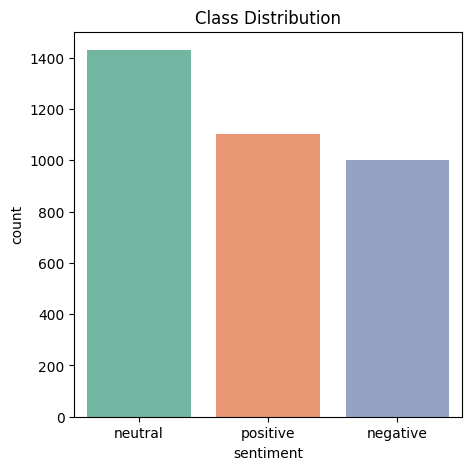

In [9]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.countplot(x=df["sentiment"], palette='Set2')
plt.title("Class Distribution")
plt.show()

#Shows that there is imbalance

In [10]:
# Upsampling done wrt Positive & Negative classes to match Neutral class to counter the imbalance as seen in the last graph diagram
from sklearn.utils import resample 

df_neutral = df[df["sentiment"] == "neutral"]
df_positive = df[df["sentiment"] == "positive"]
df_negative = df[df["sentiment"] == "negative"]

df_positive_upsampled = resample(df_positive, 
                                 replace=True,  # Allow duplicates
                                 n_samples=len(df_neutral),  
                                 random_state=42)

df_negative_upsampled = resample(df_negative, 
                                 replace=True,  
                                 n_samples=len(df_neutral),  
                                 random_state=42)

df_balanced = pd.concat([df_neutral, df_positive_upsampled, df_negative_upsampled])
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced["sentiment"].value_counts())  # Check new class distribution


sentiment
neutral     1430
positive    1430
negative    1430
Name: count, dtype: int64


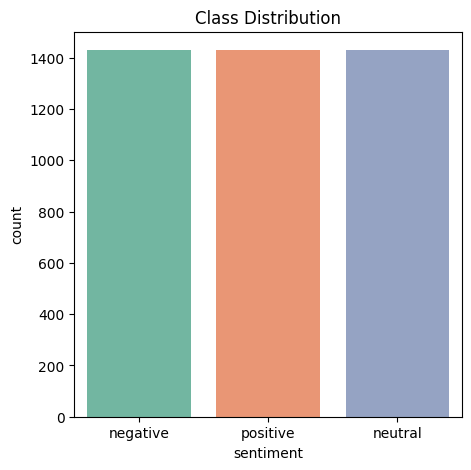

In [11]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.countplot(x=df["sentiment"], palette='Set2')
plt.title("Class Distribution")
plt.show()

#Shows that there is no imbalance

In [12]:
vectorizer=TfidfVectorizer(stop_words=None, max_features=25000, ngram_range=(1,2), min_df=3, max_df=0.8)
x_tfidf=vectorizer.fit_transform(df["cleaned_text"])


x_train_tfidf, x_test_tfidf, y_train, y_test = tts(x_tfidf, df["sentiment"], test_size=0.2, random_state=0)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_tfidf, y_train = smote.fit_resample(x_train_tfidf, y_train)

print("TF-IDF feauture extraction complete!")

TF-IDF feauture extraction complete!


In [13]:
for a in [0.001, 0.005, 0.01, 0.05, 0.1]:
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(x_train_tfidf, y_train)
    y_pred_nb = nb_model.predict(x_test_tfidf)
    print(f"Alpha {a} - Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")


print("\nNaive Bayes Accuracy: ", accuracy_score(y_test, y_pred_nb)*100)
print("\nNaive Bayes Classification Report:\n ", classification_report(y_test, y_pred_nb))



Alpha 0.001 - Accuracy: 0.7494
Alpha 0.005 - Accuracy: 0.7483
Alpha 0.01 - Accuracy: 0.7494
Alpha 0.05 - Accuracy: 0.7541
Alpha 0.1 - Accuracy: 0.7529

Naive Bayes Accuracy:  75.29137529137529

Naive Bayes Classification Report:
                precision    recall  f1-score   support

    negative       0.83      0.73      0.77       279
     neutral       0.62      0.74      0.68       287
    positive       0.85      0.79      0.82       292

    accuracy                           0.75       858
   macro avg       0.77      0.75      0.76       858
weighted avg       0.77      0.75      0.76       858



In [14]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from sklearn.model_selection import train_test_split as tts 

print(df["sentiment"].unique())


label_mapping = {"positive": 2, "neutral": 1, "negative": 0}
df["sentiment_label"] = df["sentiment"].map(label_mapping)

print(df["sentiment_label"].unique())



['negative' 'positive' 'neutral']
[0 2 1]


In [16]:
from sklearn.utils import resample

df_majority = df[df['sentiment_label'] == 2]  
df_minority = df[df['sentiment_label'] != 2]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

x_train, x_test, y_train, y_test = tts(df_balanced["cleaned_text"], df_balanced["sentiment_label"], test_size=0.2, random_state=42)


In [17]:

y_train_bert = np.array(y_train, dtype=np.int32)
y_test_bert = np.array(y_test, dtype=np.int32)


print("Sample encoded y_train:", y_train_bert[:5])  


Sample encoded y_train: [0 1 2 1 1]


In [18]:
# Ensure x_train is a list of strings and has no NaN values
x_train = x_train.dropna().astype(str).tolist()
x_test = x_test.dropna().astype(str).tolist()

def encode_text(texts, tokenizer, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# Now encode properly
train_encodings = encode_text(x_train, tokenizer)  
test_encodings = encode_text(x_test, tokenizer)
def encode_text(texts, tokenizer, max_length=128): 
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")


train_encodings = encode_text(x_train, tokenizer)  
test_encodings = encode_text(x_test, tokenizer)

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),y_train_bert )). batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),y_test_bert )). batch(8)

In [21]:
import tensorflow as tf
import keras

print("TensorFlow Version:", tf.__version__)  # Should be 2.15.0
print("Keras Version:", keras.__version__)  # Should be 2.15.0


TensorFlow Version: 2.17.1
Keras Version: 3.5.0


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [23]:
import numpy as np


preds = bert_model.predict(test_dataset).logits
predicted_labels = np.argmax(preds, axis=1)


y_test_np = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

for i in range(min(10, len(y_test_np))):  
    if predicted_labels[i] != y_test_np[i]:  
        print(f"Text: {x_test[i]}")
        print(f"Actual: {y_test_np[i]}, Predicted: {predicted_labels[i]}\n")


72/72 [==============================] - 9s 33ms/step
Text: learning tat the scenic way din plan to go town but somehow was herded there?
Actual: 1, Predicted: 0

Text: i m up wit cha!! just got home from da reggae club, wishin i was sexin somebody!!!
Actual: 2, Predicted: 0

Text: uh, happy mother s day mum.
Actual: 2, Predicted: 0

Text: wish i could go. gotta work.
Actual: 2, Predicted: 0

Text: i need a bear hug and im going to camp today!!
Actual: 1, Predicted: 0

Text: all done. no more internship.
Actual: 1, Predicted: 0

Text: crying to a walk to remember as usual
Actual: 0, Predicted: 1



In [27]:

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

from transformers import create_optimizer
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=1000)

bert_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
bert_model.fit(train_dataset, validation_data=test_dataset, epochs=8, class_weight=class_weights)




Epoch 1/8
286/286 [==============================] - 66s 113ms/step - loss: 0.7086 - accuracy: 0.7037 - val_loss: 0.4421 - val_accuracy: 0.8514
Epoch 2/8
286/286 [==============================] - 27s 93ms/step - loss: 0.3026 - accuracy: 0.9008 - val_loss: 0.3824 - val_accuracy: 0.8811
Epoch 3/8
286/286 [==============================] - 27s 93ms/step - loss: 0.1429 - accuracy: 0.9611 - val_loss: 0.3658 - val_accuracy: 0.8899
Epoch 4/8
286/286 [==============================] - 27s 93ms/step - loss: 0.0875 - accuracy: 0.9781 - val_loss: 0.3637 - val_accuracy: 0.8969
Epoch 5/8
286/286 [==============================] - 27s 94ms/step - loss: 0.0788 - accuracy: 0.9847 - val_loss: 0.3637 - val_accuracy: 0.8969
Epoch 6/8
286/286 [==============================] - 27s 93ms/step - loss: 0.0802 - accuracy: 0.9830 - val_loss: 0.3637 - val_accuracy: 0.8969
Epoch 7/8
286/286 [==============================] - 27s 93ms/step - loss: 0.0758 - accuracy: 0.9851 - val_loss: 0.3637 - val_accuracy: 0.896

In [28]:
loss, accuracy = bert_model.evaluate(test_dataset)
print(f"Final BERT Test Accuracy: {accuracy * 100:.2f}%")

72/72 [==============================] - 3s 36ms/step - loss: 0.3637 - accuracy: 0.8969
Final BERT Test Accuracy: 89.69%


In [31]:
import numpy as np


preds = bert_model.predict(test_dataset).logits
predicted_labels = np.argmax(preds, axis=1)


y_test_np = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)


for i in range(min(10, len(y_test_np))):  # Displays 10 incorrect predictions
    if predicted_labels[i] != y_test_np[i]:  
        print(f"Text: {x_test[i]}")
        print(f"Actual: {y_test_np[i]}, Predicted: {predicted_labels[i]}\n")


72/72 [==============================] - 3s 35ms/step
Text: i m siiiiiickkk i dun feel good!!
Actual: 0, Predicted: 2

Text: i need a bear hug and im going to camp today!!
Actual: 1, Predicted: 2



In [32]:
bert_model.save_pretrained("bert_sentiment_model")
tokenizer.save_pretrained("bert_sentiment_model")


('bert_sentiment_model/tokenizer_config.json',
 'bert_sentiment_model/special_tokens_map.json',
 'bert_sentiment_model/vocab.txt',
 'bert_sentiment_model/added_tokens.json')

In [34]:
from transformers import TFBertForSequenceClassification, BertTokenizer

model = TFBertForSequenceClassification.from_pretrained("bert_sentiment_model")
tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model")


Some layers from the model checkpoint at bert_sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_sentiment_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [49]:
def predict_sentiment(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=128)
    logits = model(inputs["input_ids"]).logits
    predicted_class = np.argmax(logits, axis=1)[0]
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_mapping[predicted_class]

text = "I love this product! It's amazing."
print("Predicted Sentiment for",text," -> ", predict_sentiment(text, bert_model, tokenizer), "\n")

text1="Disgusting Product ! Would never recommend it."
print("Predicted Sentiment for",text1," -> ", predict_sentiment(text1, bert_model, tokenizer), "\n" )

text2="It's decent ! Not Bad Not Good"
print("Predicted Sentiment for",text2," -> ", predict_sentiment(text2, bert_model, tokenizer), "\n" )

Predicted Sentiment for I love this product! It's amazing.  ->  Positive 

Predicted Sentiment for Disgusting Product ! Would never recommend it.  ->  Negative 

Predicted Sentiment for It's decent ! Not Bad Not Good  ->  Neutral 



In [50]:
from sklearn.metrics import classification_report


preds = bert_model.predict(test_dataset).logits
predicted_labels = np.argmax(preds, axis=1)


y_test_np = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)


report = classification_report(y_test_np, predicted_labels, target_names=["Negative", "Neutral", "Positive"])
print(report)


72/72 [==============================] - 3s 35ms/step
              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90       138
     Neutral       0.84      0.77      0.80       139
    Positive       0.93      0.95      0.94       295

    accuracy                           0.90       572
   macro avg       0.88      0.88      0.88       572
weighted avg       0.90      0.90      0.90       572



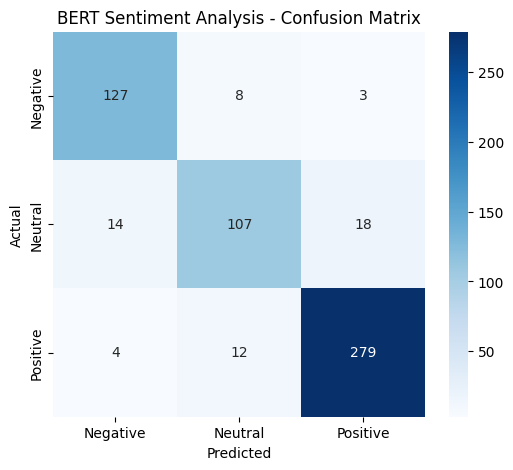

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_np, predicted_labels)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BERT Sentiment Analysis - Confusion Matrix")
plt.show()


In [53]:
pip install streamlit transformers tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 68.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [54]:
#WEB DEPLOYMENT

import streamlit as st
from transformers import TFBertForSequenceClassification, BertTokenizer
import numpy as np


@st.cache_resource  
def load_model():
    model = TFBertForSequenceClassification.from_pretrained("bert_sentiment_model")
    tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model")
    return model, tokenizer

model, tokenizer = load_model()


def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=128)
    logits = model(inputs["input_ids"]).logits
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_mapping[np.argmax(logits)]


st.title("🔥 Sentiment Analysis Web App 🔥")
st.write("Enter a sentence below to analyze its sentiment.")

user_input = st.text_area("Enter text here:")
if st.button("Predict Sentiment"):
    if user_input.strip():
        sentiment = predict_sentiment(user_input)
        st.success(f"Predicted Sentiment: **{sentiment}**")
    else:
        st.warning("⚠️ Please enter some text before predicting!")


2025-03-02 17:43:09.824 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 17:43:09.936 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-02 17:43:09.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 17:43:09.938 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 17:43:10.439 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 17:43:10.440 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
Some layers from the model checkpoint at bert_sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initi